In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import torch
import numpy as np
import pythreejs as pjs
import warnings
warnings.filterwarnings('ignore')

from matplotlib.cm import get_cmap
from tqdm.notebook import tqdm
from PIL import Image
from IPython.core.display import display

os.chdir('..')
np.set_printoptions(precision=4)
!pwd

/home/chungwoo/workspace/panodepth-vidar/dgp


In [2]:
from vidar.utils.write import viz_depth, viz_inv_depth

In [3]:
from vidar.utils.config import read_config
from vidar.utils.setup import setup_arch, setup_dataset

def load_model_and_dataset(file):
    config = read_config(file)
    config.datasets.validation.labels += ['pose']
    config.datasets.validation.path = [
        '/data/datasets/DDAD/ddad_train_val/ddad.json'
    ]
    
    dataset = setup_dataset(config.datasets.validation, verbose=True)
    
    model = setup_arch(config.arch, checkpoint=None, verbose=True)

    
    return model, dataset


models = dict()
datasets = dict()

config_files = {    
    'FSM': 'configs/papers/fsm/inference_ddad.yaml'
}

for model_name, cfg_file in config_files.items():
    models[model_name], datasets[model_name] = load_model_and_dataset(cfg_file)

#### Ouroboros: 
	 3950 samples | context [] | cameras [1,5,6,7,8,9] | labels ['depth','pose']
	 | augmentation Config(resize=[384,640])
############################################################
### Preparing Architecture
############################################################
###### Model:
######### FSMModel
###### Networks:
######### FocalDepthResNet (14,842,236 parameters)
######### ConvPoseNet (1,592,684 parameters)
############################################################
###### Loading from checkpoint: /data/models/papers/FSM_MR_6cams_DDAD.ckpt
###### Loaded 180/180 tensors
############################################################


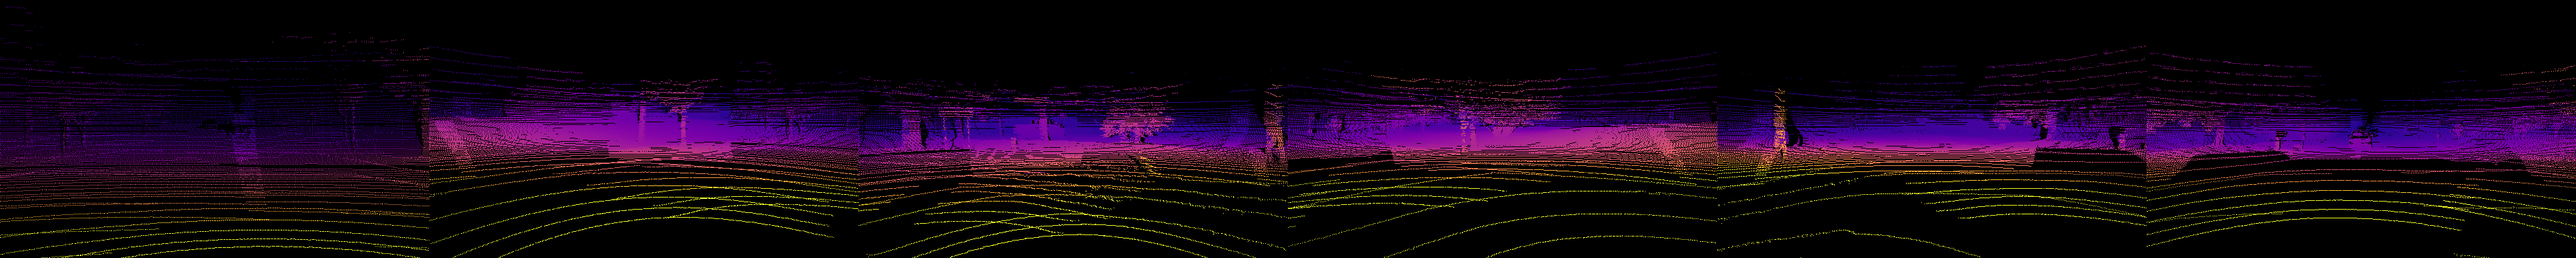

In [4]:
from torch.utils.data.dataloader import default_collate

from vidar.datasets.augmentations.resize import resize_npy_preserve, resize_torch_preserve
from vidar.geometry.camera import Camera

batches = dict()
outputs = dict()

video_idx = 0
batch_idx = 0

model_names = list(config_files.keys())

batch = default_collate([datasets['FSM'][video_idx][batch_idx]])
blob = zip(batch['extrinsics'][0][0], batch['intrinsics'][0][0], batch['rgb'][0][0])
cam = {k: Camera(intrinsic[None], rgb, Twc=extrinsic[None].float(), name=k) 
            for k, (extrinsic, intrinsic, rgb) in enumerate(blob)}

points_gt = []
colors_gt = []

depth_gt = resize_torch_preserve(batch['depth'][0][0].cpu(), (384, 640))
rgb_images = batch['rgb'][0][0].cpu() 

display(Image.fromarray(np.hstack(
    [(viz_depth(d, filter_zeros=True) * 255.0).astype(np.uint8) for d in depth_gt]
)))
for key, val in cam.items():    
    xyz_world_gt = cam[key].reconstruct_depth_map(depth_gt[key][None], to_world=True)
    points_gt.append(xyz_world_gt.reshape(3, -1).T)
    colors_gt.append(rgb_images[key].reshape(3, -1).T)

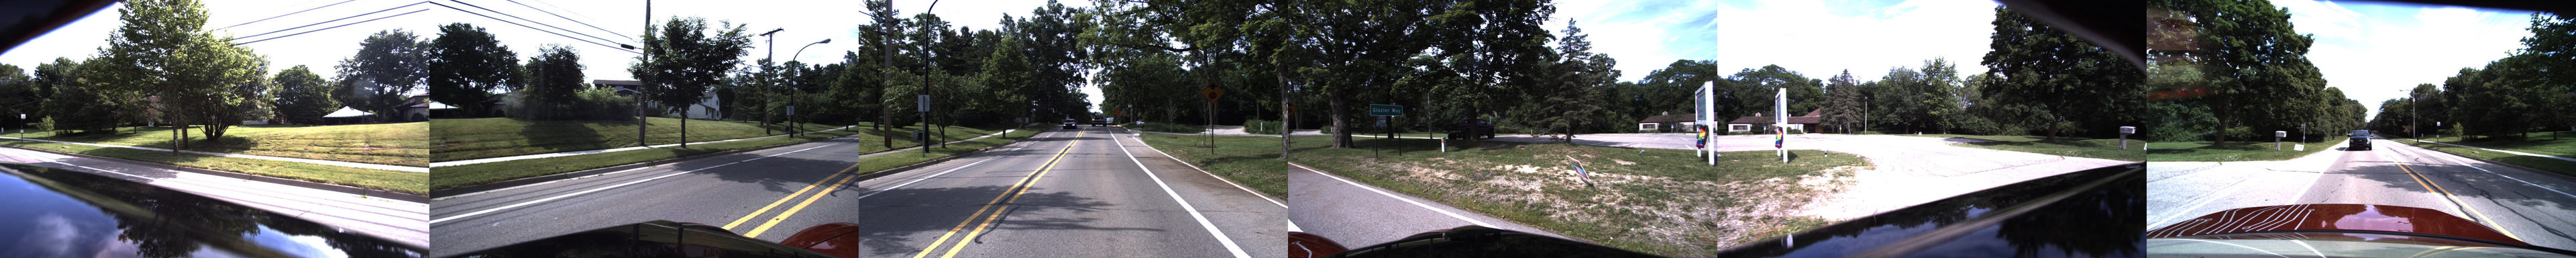

FSM


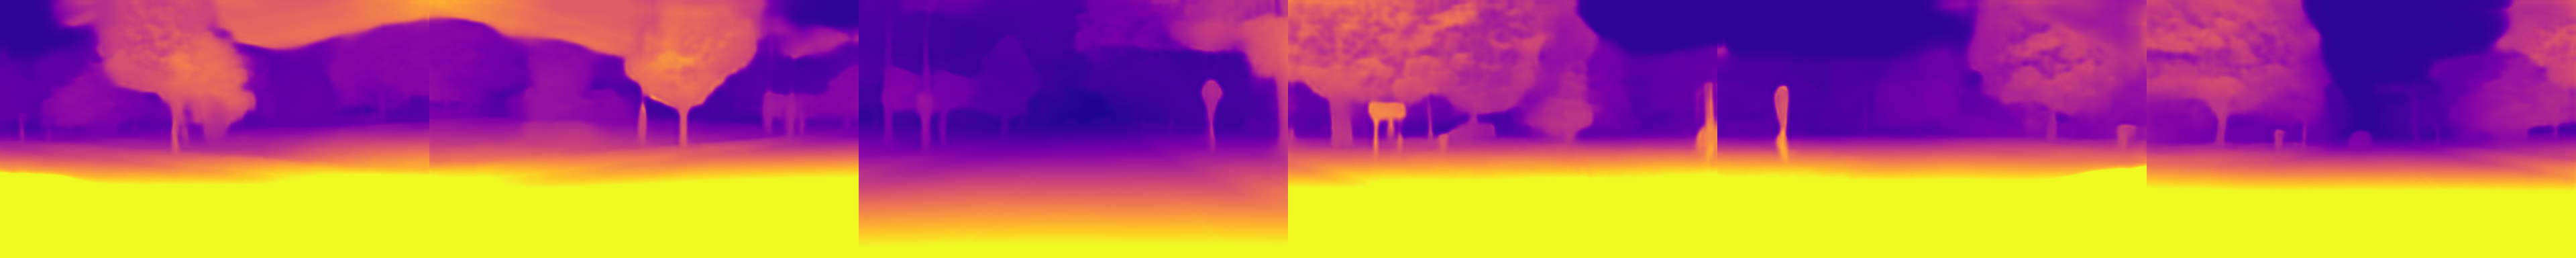

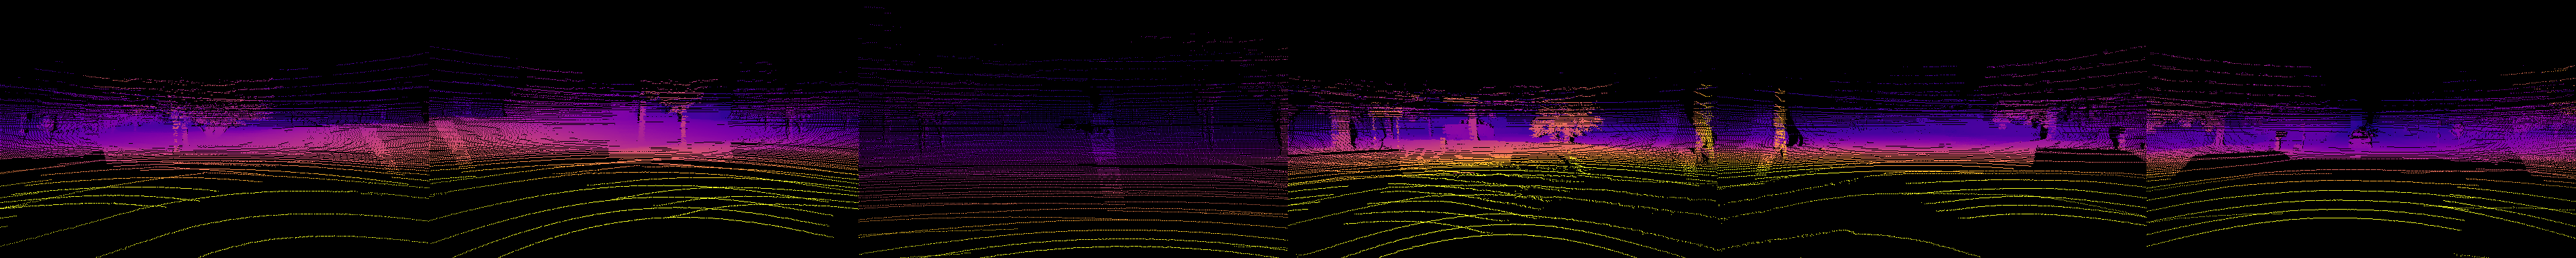

In [5]:
import functools
from collections import defaultdict
from IPython.display import display
from ipywidgets import Checkbox, VBox, HBox
from vidar.utils.depth import depth2inv
    
camera_names = ['camera_01', 'camera_05', 'camera_06', 'camera_07', 'camera_08', 'camera_09']
camera_order = [3, 1, 0, 2, 4, 5]

points = defaultdict(list)
colors = defaultdict(list)

normalizer = None

for ii, model_name in enumerate(model_names):
    batch = default_collate([datasets[model_name][video_idx][batch_idx]])
    batches[model_name] = batch
    
    models[model_name].eval()
    output = models[model_name](batch, epoch=0, return_logs=False)
    outputs[model_name] = output
    
    if ii == 0:
        display(Image.fromarray(np.hstack(
            [(batch['rgb'][0][0][o].permute(1, 2, 0).detach().cpu().numpy() * 255.0).astype(np.uint8) for o in camera_order]
        )))



    print(model_name)
    if model_name in ['FSM']:
        output_key = 'depth'
        
        depth = output['predictions'][output_key][0][0][0].detach().cpu()
        color = batch['rgb'][0][0].detach().cpu()
        
        if normalizer is None:
            inv_depth = depth2inv(depth[0].cpu())    
            normalizer = np.percentile(inv_depth[inv_depth > 0], 95)

        display(Image.fromarray(np.hstack(
            [(viz_depth(depth[o][0], normalizer=normalizer) * 255.0).astype(np.uint8) for o in camera_order]
        )))

        depth_gt = resize_torch_preserve(batch['depth'][0][0].cpu(), (384, 640))

        display(Image.fromarray(np.hstack(
            [(viz_depth(depth_gt[o], normalizer=normalizer) * 255.0).astype(np.uint8) for o in camera_order]
        )))

        for key, val in cam.items():
            xyz_world = cam[key].reconstruct_depth_map(depth[key][None], to_world=True)
            points[model_name].append(xyz_world.reshape(3, -1).T)
            colors[model_name].append(color[key].reshape(3, -1).T)


In [6]:
def visualize_3d_list(xyz_list, rgb_list, size=0.03, height=480, width=480):
    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointClouds = []
    for xyz, rgb in zip(xyz_list, rgb_list):
        points_buf = pjs.BufferAttribute(array=xyz)
        geometryAttrs = {'position': points_buf}

        colors_buf = pjs.BufferAttribute(array=rgb)
        geometryAttrs['color'] = colors_buf

        geometry = pjs.BufferGeometry(attributes=geometryAttrs)
        pointClouds.append(pjs.Points(geometry=geometry, material=material))

    pythreejs_camera = pjs.PerspectiveCamera(
        up=[1, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)

    axes = pjs.AxesHelper(size=3)

    scene = pjs.Scene(children=pointClouds + [
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777'),
                    axes])

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

In [7]:
import torch
import numpy as np

def calculate_depth_metrics(gt, pred, min_depth=1, max_depth=80):
    gt = gt.squeeze()
    valid = (gt > min_depth) & (gt < max_depth) & (pred > 0)

    
    gt_valid, pred_valid = gt[valid], pred[valid]
    
    abs_rel = torch.mean(torch.abs(gt_valid - pred_valid) / gt_valid)
    sqr_rel = torch.mean(((gt_valid - pred_valid) ** 2) / gt_valid)
    rmse = torch.sqrt(torch.mean((gt_valid - pred_valid) ** 2))
    rmse_log = torch.sqrt(torch.mean((torch.log(gt_valid + 1) - torch.log(pred_valid + 1)) ** 2))

    silog = torch.sqrt(torch.mean((torch.log(pred_valid + 1) - torch.log(gt_valid + 1)) ** 2) - (torch.mean(torch.log(pred_valid + 1) - torch.log(gt_valid + 1))) ** 2) * 100
    
    thresh = torch.max((gt_valid / pred_valid), (pred_valid / gt_valid))
    a1 = (thresh < 1.25).float().mean()
    a2 = (thresh < 1.25 ** 2).float().mean()
    a3 = (thresh < 1.25 ** 3).float().mean()

    return {'abs_rel': abs_rel.item(), 'sqr_rel': sqr_rel.item(), 'rmse': rmse.item(), 'rmse_log': rmse_log.item(), 'silog': silog.item(), 'a1': a1.item(), 'a2': a2.item(), 'a3': a3.item()}

def print_depth_evaluation(metrics):
    metrics_names = list(metrics.keys())
    metrics_values = list(metrics.values())
        
    width = 14 * len(metrics_names)
    print('|{:<}|'.format('*' * width))
    print('| {:^15} |'.format("Metric") + ' '.join([' {:^8} |'.format(name) for name in metrics_names]))
    print('|{:<}|'.format('*' * width))
    print('| {:^15} |'.format(camera_name) + ' '.join([' {:^8.3f} |'.format(value) for value in metrics_values]))
    print('|{:<}|'.format('*' * width))

for camera_name in camera_names:
     
    camera_idx = camera_order[camera_names.index(camera_name)]
    
    pred_depth = depth[camera_idx][0]
    
    gt_depth = depth_gt[camera_idx]
    
    metrics = calculate_depth_metrics(gt_depth, pred_depth)
    
    print_depth_evaluation(metrics)



|****************************************************************************************************************|
|     Metric      | abs_rel  |  sqr_rel  |    rmse   |  rmse_log |   silog   |     a1    |     a2    |     a3    |
|****************************************************************************************************************|
|    camera_01    |  0.183   |   1.963   |   9.120   |   0.283   |   25.416  |   0.713   |   0.893   |   0.950   |
|****************************************************************************************************************|
|****************************************************************************************************************|
|     Metric      | abs_rel  |  sqr_rel  |    rmse   |  rmse_log |   silog   |     a1    |     a2    |     a3    |
|****************************************************************************************************************|
|    camera_05    |  0.146   |   1.461   |   7.526   |   0.247   |   23.835  |  